# GPJM: fMRI Experiment

11/09/2019

Giwon Bahg

Fit the GPJM with three-dimensional latent dynamics. Note that this model does not consider the spatial relationship between regions of interest (ROIs), unlike the simulation study.

## Import packages and data

In [3]:
import numpy as np
!pip install gpflow
import gpflow
import tensorflow as tf
import time
from gpflow.utilities import ops, print_summary  

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 383 kB 5.1 MB/s 
     |████████████████████████████████| 104 kB 69.3 MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Time indices
time_block = np.load("/content/drive/MyDrive/Tesis/fMRI_DATOS/time_block.npy")
ts_dense = np.load("/content/drive/MyDrive/Tesis/fMRI_DATOS/ts_dense.npy") # Time indices for behavioral data
ts_sparse = np.load("/content/drive/MyDrive/Tesis/fMRI_DATOS/ts_sparse.npy") # Time indices for neural data

In [6]:
# Time indices for the fixation onset (i.e., beginning of new trials)
#Va de 39 en 39 hasta 744
fix_onset = np.array([  0.,  39.,  78., 117., 156., 195., 235., 274., 313., 353., 393., 431., 469., 508., 547., 587., 627., 665., 705., 744.], dtype=np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Load the coherence information
# Only the variable 'coh1', which corresponds to the first run of the experiment, is used.
#coh = np.zeros((ts_sparse.shape[0], 4))
#for block in range(4):
    #coh[:,block] = np.load("/content/drive/MyDrive/Tesis/fMRI_DATOS/coherence_scaled_sub13_run"+str(block+1)+".npy")[:,0]

#coh0 = coh.T.ravel().reshape(-1,1)
coh1 = np.load("/content/drive/MyDrive/Tesis/fMRI_DATOS/coherence_scaled_013_run1.npy")

# Upscale the coherence
coh1_ext = np.column_stack([coh1, coh1]).ravel()
coh1_ext = coh1_ext[0:(len(coh1_ext)-1)]
coh1 = coh1_ext.reshape(-1,1)

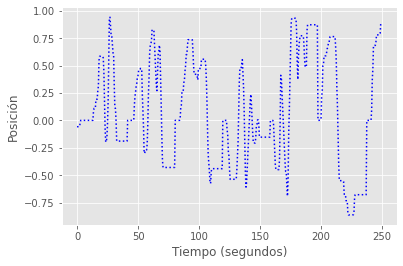

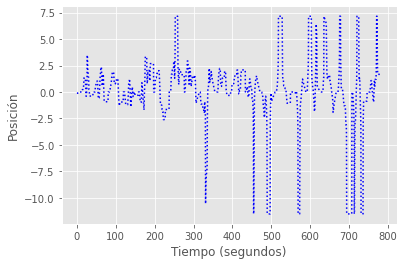

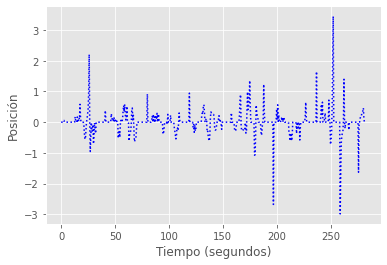

In [9]:
# Load the mouse trajectory
# Only the variable 'Y_B1' is used.
#Y_B = np.zeros((ts_dense.shape[0], 4))
#for block in range(4):
 #   Y_B[:,block] = np.load("/content/drive/MyDrive/Tesis/fMRI_DATOS/mouse_trajectory_centered_scaled_sub13_run"+str(block+1)+".npy")[:,0]

#Y_B0 = Y_B.T.ravel().reshape(-1,1)
Y_B1 = np.load("/content/drive/MyDrive/Tesis/fMRI_DATOS/mouse_trajectory_centered_scaled_013_run1.npy")

plt.plot(ts_dense[0:500], Y_B1[0:500], linestyle=":", color="blue", label="Datos de comportamiento")
plt.ylabel("Posición")
#.grid(color='b', ls = '-.', lw = 0.25)
plt.xlabel("Tiempo (segundos)")

plt.show()

# Logit-transform the behavioral data
temp = Y_B1/2 + 0.5
temp[np.where(temp == 0)[0]] = 1e-5
Y_B1 = np.log(temp/(1-temp))

plt.plot(ts_dense, Y_B1, linestyle=":", color="blue", label="Transformaciín logit a datos de comportamiento")
plt.ylabel("Posición")
#.grid(color='b', ls = '-.', lw = 0.25)
plt.xlabel("Tiempo (segundos)")

plt.show()

plt.plot(ts_dense[0:566], Y_B1[1:567]-Y_B1[0:566], linestyle=":", color="blue", label="Transformaciín logit a datos de comportamiento")
plt.ylabel("Posición")
#.grid(color='b', ls = '-.', lw = 0.25)
plt.xlabel("Tiempo (segundos)")

plt.show()

# Store the original value separately
#Y_B1_org = np.load("mouse_trajectory_centered_scaled_sub13_run1.npy")

In [10]:
# Load the neural data
Y_N1 = np.load("/content/drive/MyDrive/Tesis/fMRI_DATOS/Timing013_meanTS_block1.npy")
# Y_N2 = np.load("Timing013_meanTS_block2.npy") # Not used
# Y_N3 = np.load("Timing013_meanTS_block3.npy")
# Y_N4 = np.load("Timing013_meanTS_block4.npy")

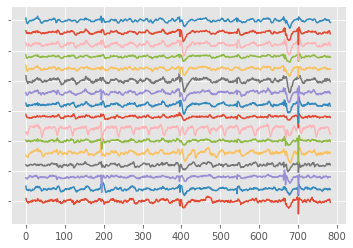

In [11]:
for i in range(16):
  plt.plot(ts_sparse, Y_N1[:,i]+i*4)

plt.yticks(visible = False) 

plt.show()

In [12]:
# ROI information: Not used for fitting the model.
## Coherence-related regions
ss_RC = np.array([[-54, 23, 0], [32, -23, 64], [29, -69, -41], [-48, 48, -14], [-9, -88, 26], [49, -40, 9], [7, -72, -9]], dtype = np.float64)
## Behavioral-response-related regions
ss_resp = np.array([[66, -3, 22], [54, -14, 6], [-44, -64, 11], [10, -6, 72], [-44, -3, 61], [-52, 0, 32], [60, -25, 13], [-53, -21, 10], [-10, -56, 68]], dtype = np.float64)

ss = np.vstack([ss_RC, ss_resp])

# ROI labels
label_ROI = np.array(['RC1_IFG', 'RC2_PCG', 'RC3_CRUS2', 'RC4_FP', 'RC5_OP', 'RC6_PSG', 'RC7_LG',
            'resp1_SSC1', 'resp2_AC1', 'resp3_V5', 'resp4_PMC(SFG)', 'resp5_PMC(MFG)','resp6_MC1', 'resp7_IPL', 'resp8_AC1', 'resp9_SPL'])

## Set up the model

In [13]:
# Generate a convolved RBF kernel 
class KernelHRFConvDownsized_RBF(gpflow.kernels.Kernel):
    def __init__(self, ts_N, ts_dense):
        super().__init__()
        # Set the basis kernel-Define el kernel exponencial
        self.kernel = gpflow.kernels.SquaredExponential()
        # Set the HRF-Define la función hemodinámica
        def HRF_filter(ts_dense):
            ts = np.squeeze(ts_dense)
            unit_ts = ts[ts <= 30]
            def HRFunit(t):
                from scipy.special import gamma
                a1 = 6 # b1=1
                a2 = 16 # b2=1
                c = 1./6
                part1 = t**(a1-1) * np.exp(-t) / gamma(a1)
                part2 = t**(a2-1) * np.exp(-t) / gamma(a2)
                return part1 - c * part2
            hrf = HRFunit(unit_ts)
            return(hrf)
        self.hrf_dense = tf.constant(np.flip(HRF_filter(ts_dense)))
        self.len_hrf_dense = self.hrf_dense.shape[0]
        # Set the downsizing scheme
        def downsizing_scheme_nearest(ts_N, ts_dense):
            M = np.zeros((ts_dense.shape[0], ts_N.shape[0]))
            ts = np.squeeze(ts_dense)
            for i in range(ts_N.shape[0]):
                argmin_idx = np.argmin(np.abs(ts - ts_N[i,0]))
                M[argmin_idx,i] = 1
            return M
        self.M = tf.constant(downsizing_scheme_nearest(ts_N, ts_dense))

    def K(self, X, X2=None, presliced=False):
        if X2 is None:
            X2=X
        padK = tf.pad(self.kernel.K(X, X2), [[self.len_hrf_dense-1, 0],[self.len_hrf_dense-1,0]], 'CONSTANT')
        hrf4conv = tf.reshape(self.hrf_dense, [self.len_hrf_dense, 1, 1])
        temp0 = tf.reshape(padK, [tf.shape(padK)[0], tf.shape(padK)[1], 1], name='temp0')
        res0 = tf.squeeze(tf.nn.conv1d(temp0, hrf4conv, 1, 'VALID'))
        temp1 = tf.reshape(tf.transpose(res0), [tf.shape(res0)[1], tf.shape(res0)[0], 1], name='temp1')
        res1 = tf.transpose(tf.squeeze(tf.nn.conv1d(temp1, hrf4conv, 1, 'VALID')))
        # Downsample the dense kernel
        res2 = tf.matmul(tf.transpose(self.M), tf.matmul(res1, self.M))
        return(res2)

    def K_diag(self, X, X2=None, presliced=False):                      # 2022-02 RMC upd07: now when creating a kernel it is necessary to define abstract method K_diag
        if X2 is None:
            X2=X
        padK = tf.pad(self.kernel.K(X, X2), [[self.len_hrf_dense-1, 0],[self.len_hrf_dense-1,0]], 'CONSTANT')
        hrf4conv = tf.reshape(self.hrf_dense, [self.len_hrf_dense, 1, 1])
        temp0 = tf.reshape(padK, [tf.shape(padK)[0], tf.shape(padK)[1], 1], name='temp0')
        res0 = tf.squeeze(tf.nn.conv1d(temp0, hrf4conv, 1, 'VALID'))
        temp1 = tf.reshape(tf.transpose(res0), [tf.shape(res0)[1], tf.shape(res0)[0], 1], name='temp1')
        res1 = tf.transpose(tf.squeeze(tf.nn.conv1d(temp1, hrf4conv, 1, 'VALID')))
        # Downsample the dense kernel
        res2 = tf.matmul(tf.transpose(self.M), tf.matmul(res1, self.M))
        return(res2)

In [ ]:
class GPJMv2(gpflow.models.GPR):
    def __init__(self, Y_N, Y_B, ts_N, ts_B, n_latent, ss, conv_scheme = KernelHRFConvDownsized_RBF,
                 kern_tX = None, mean_tX = None, kern_XN = None, mean_XN = None, kern_XB = None, mean_XB = None, name=None):
        if kern_tX is None:
            kern_tX = gpflow.kernels.SquaredExponential() 
        if mean_tX is None:
            mean_tX = gpflow.mean_functions.Zero(output_dim =n_latent)
        if kern_XN is None:
            kern_XN = conv_scheme(ts_N = ts_N, ts_dense = ts_B)
        if mean_XN is None:
            mean_XN = gpflow.mean_functions.Zero(output_dim = Y_N.shape[1])
        if kern_XB is None:
            kern_XB = gpflow.kernels.Matern12()
        if mean_XB is None:
            mean_XB = gpflow.mean_functions.Zero(output_dim = Y_B.shape[1])
       # super().__init__(name=name)
        
        def cubic_interpolation(ts_sparse, Y_N, ts_dense, ss):
            from scipy import interpolate
            yn_new = np.zeros((ts_dense.shape[0], ss.shape[0]))
            yn_array = Y_N.reshape(ss.shape[0], ts_sparse.shape[0]).T
            for i in range(ss.shape[0]):
                temp = interpolate.interp1d(np.squeeze(ts_sparse), yn_array[:,i], kind='cubic')
                yn_new[:,i] = temp(np.squeeze(ts_dense))
            return yn_new
        
        def downsizing_scheme_nearest(ts_sparse, ts_dense):
            M = np.zeros((ts_dense.shape[0], ts_sparse.shape[0]))
            ts = np.squeeze(ts_dense)
            for i in range(ts_sparse.shape[0]):
                argmin_idx = np.argmin(np.abs(ts - ts_sparse[i,0]))
                M[argmin_idx,i] = 1
            return M
        
        def HRF_filter(ts_dense):
            ts = np.squeeze(ts_dense)
            unit_ts = ts[ts <= 30]
            def HRFunit(t):
                from scipy.special import gamma
                a1 = 6 # b1=1
                a2 = 16 # b2=1
                c = 1./6
                part1 = t**(a1-1) * np.exp(-t) / gamma(a1)
                part2 = t**(a2-1) * np.exp(-t) / gamma(a2)
                return part1 - c * part2
            hrf = HRFunit(unit_ts)
            return(hrf)
        
        if len(ts_N) > len(ts_B):
            print("Neural: Dense / Behavioral: Sparse")
            self.ts = tf.constant(ts_N.copy())
        elif len(ts_N) < len(ts_B):
            print("Neural: Sparse / Behavioral: Dense")
            self.ts = tf.constant(ts_B.copy())
            self.ts_dense = ts_B.copy()
            self.Y_N_interp = cubic_interpolation(ts_N, Y_N, ts_B, ss)
            self.M = downsizing_scheme_nearest(ts_N, ts_B)
        
        # Data
        self.Y_N = tf.constant(Y_N.copy())
        self.Y_B = tf.constant(Y_B.copy())
        self.ts_N = tf.constant(ts_N.copy())
        self.ts_B = tf.constant(ts_B.copy())
        self.n_Nsample = Y_N.shape[0]
        self.n_Nfeature = Y_N.shape[1]
        self.n_Bsample = Y_B.shape[0]
        self.n_Bfeature = Y_B.shape[1]
        
        # latent dynamics kernel + downsizing scheme
        self.kern_tX = kern_tX
        self.mean_tX = mean_tX
        self.n_latent = n_latent
        self.N_pca = ops.pca_reduce(self.Y_N_interp, n_latent)
        self.X = gpflow.Parameter(ops.pca_reduce(self.Y_N_interp, n_latent))
        self.X_sparse = ops.pca_reduce(Y_N, n_latent)

        # Neural data kernel
        self.kern_XN = kern_XN
        self.mean_XN = mean_XN
        self.hrf = tf.constant(HRF_filter(self.ts_dense))
        
        # Behavioral data kernel
        self.kern_XB = kern_XB
        self.mean_XB = mean_XB

        # Likelihood
        self.likelihood_tX = gpflow.likelihoods.Gaussian()
        self.likelihood_XN = gpflow.likelihoods.Gaussian()
        self.likelihood_XB = gpflow.likelihoods.Gaussian() # Can differ according to the model you rely on.
    
    #@gpflow.params_as_tensors
    def _build_likelihood_tX(self): # Zero-noise model is not supported by GPflow ==> Need to add an infinitesimal noise when initializing the model.
        Ktx = self.kern_tX.K(self.ts, self.ts) + tf.eye(tf.shape(self.ts)[0], dtype =tf.dtypes.float64) * self.likelihood_tX.variance
        Ltx = tf.linalg.cholesky(Ktx)
        mtx = self.mean_tX(self.ts)
        logpdf_tx = gpflow.logdensities.multivariate_normal(self.X, mtx, Ltx)
        return tf.reduce_sum(logpdf_tx)
    
    #@gpflow.params_as_tensors
    def _build_likelihood_XN(self):
        Kxn = self.kern_XN.K(self.X, self.X) + tf.eye(self.n_Nsample, dtype =tf.dtypes.float64) * self.likelihood_XN.variance
        Lxn = tf.linalg.cholesky(Kxn)
      
        mxn = self.mean_XN(self.X_sparse)
        logpdf_xn = gpflow.logdensities.multivariate_normal(self.Y_N, mxn, Lxn)
        return tf.reduce_sum(logpdf_xn)

    #@gpflow.params_as_tensors
    def _build_likelihood_XB(self):
        Kxb = self.kern_XB.K(self.X, self.X) + tf.eye(tf.shape(self.X)[0], dtype = tf.dtypes.float64) * self.likelihood_XB.variance
        Lxb = tf.linalg.cholesky(Kxb)
      
        mxb = self.mean_XB(self.X)
        logpdf_xb = gpflow.logdensities.multivariate_normal(self.Y_B, mxb, Lxb)
        return tf.reduce_sum(logpdf_xb)
    
    def maximum_log_likelihood_objective(self):     # 2022-02 RMC upd03: Abstract function for calculating log_likelihood now is named like this. (Was this the purpose of this function "_build_likelihood"?)
        with tf.name_scope('likelihood') as scope:  # 2022-02 RMC upd02: This is how name_scopes are defined nowaways.
            logpdf_tx = self._build_likelihood_tX()
            logpdf_xn = self._build_likelihood_XN()
            logpdf_xb = self._build_likelihood_XB()
            return tf.reduce_sum(logpdf_tx + logpdf_xn + logpdf_xb)
   

In [ ]:
# Functions for extractitng the model fitting results
def recover_Kxn(m, ts_new):
    X_new = recover_latent(m, ts_new)
    X = m.X.numpy()
    ss =m.ss.numpy()
    kern_temporal = m.kern_XN.kernel_t(X, X_new).numpy()
    kern_spatial = m.kern_XN.kernel_s(ss, ss).numpy()
    ts_N =m.ts_N.numpy()
        
    i, k, s = ss.shape[0], ts_N.shape[0], ts_N.shape[0]
    o = s * (i - 1) + k
  
    Kss = tf.reshape(kern_spatial, [1, i, i, 1])
    Ktt = tf.reshape(kern_temporal, [k, k, 1, 1])
    Kst = tf.squeeze(tf.nn.conv2d_transpose(Kss, Ktt, (1, o, o, 1), [1, s, s, 1], "VALID"))
    return Kst



def recover_latent(m, ts_new):
    import tensorflow as tf
    from numpy.linalg import inv, cholesky
    ts = m.ts.numpy()
    Kstar = m.kern_tX(ts, ts_new).numpy()
    KttI = (m.kern_tX(ts, ts) + np.eye(ts.shape[0], dtype=np.float64) * m.likelihood_tX.variance).numpy()
    X = m.X.numpy()
    L = cholesky(KttI)
    return Kstar.T.dot(inv(L.T).dot((inv(L)).dot(X)))



def recover_neural(m, ts_new):
    import tensorflow as tf
    from numpy.linalg import inv, cholesky
    #ts =m.ts_N.numpy()
    ts_N =m.ts_N.numpy()
    #ss =m.ss.numpy()
    Y_N = m.Y_N.numpy()
    X_new = recover_latent(m, ts_new)
    X = m.X.numpy()
    Kstar = m.kern_XN(X, X_new).numpy()
    KttI = (m.kern_XN(X, X) + np.eye(Y_N.shape[0], dtype = np.float64) * m.likelihood_XN.variance).numpy()
    L = cholesky(KttI)
    fmean = Kstar.T.dot(inv(L.T).dot((inv(L)).dot(Y_N)))
    v = inv(L).dot(Kstar)
    Vstar = Kstar - v.T.dot(v)
    sd = np.sqrt(np.diag(Vstar))
    return fmean, Vstar, sd




def recover_behavioral(m, ts_new):
    import tensorflow as tf
    from numpy.linalg import inv, cholesky
    X = m.X.numpy()
    Kstar = m.kern_XB(X, X).numpy()
    KttI = (m.kern_XB(X, X) + np.eye(m.Y_B.shape[0], dtype = np.float64) * m.likelihood_XB.variance).numpy()
    Y_B = m.Y_B.numpy()
    L = cholesky(KttI)
    fmean = Kstar.T.dot(inv(L.T).dot((inv(L)).dot(Y_B)))
    v = inv(L).dot(Kstar)
    Vstar = m.kern_XB(X, X).numpy() - v.T.dot(v)
    ci95 = np.column_stack([fmean - 1.96 * np.sqrt(np.diag(Vstar)).reshape(-1,1), fmean + 1.96 * np.sqrt(np.diag(Vstar)).reshape(-1,1)])
    return fmean, Vstar, ci95


## Fit the model

In [ ]:
test = GPJMv2(Y_N1, Y_B1, ts_sparse, ts_dense, 3, ss)
#test.likelihood_tX.variance = 1e-6
#test.likelihood_tX.variance.trainable = False

test.likelihood_tX.variance = 1e-6
gpflow.set_trainable(test.likelihood_tX, False)        # 2022-02 RMC upd11: trainable attributes are not assigned directly anymore, but need a method


Neural: Sparse / Behavioral: Dense


In [ ]:

# Fit the model to the data.
#opt = gpflow.optimizers.Scipy()
#print(len(test.trainable_variables))
#print(test2.trainable_variables.shape)
#opt.minimize(test.training_loss, variables=test.trainable_variables, allow_unused_variables=True) 
print("2-var done")


9


KeyboardInterrupt: ignored

In [ ]:

#natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)

#adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    #adam_opt = tf.optimizers.Adam(0.2)
    #natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(test.training_loss, test.trainable_variables)

In [ ]:
# Run for 600 iterations
# Save the results every 20 iterations (for back-up)
max_iter = 600
record_step = 20
X_storage = np.zeros((test.X.shape[0], test.X.shape[1], (max_iter+1)))
llk_storage = np.zeros(max_iter+1)
learning_rate_vec_temp = 0.2/np.sqrt(np.arange(max_iter)+1)
learning_rate_vec = np.zeros_like(learning_rate_vec_temp)
for i in range(len(learning_rate_vec_temp)):
    learning_rate_vec[i] = learning_rate_vec_temp[int(np.floor(i/record_step))]

#saved_at = 0
#llk_storage = np.zeros(max_iter+1)
#llk_storage[0] = test.training_loss().numpy()

# Fit the model

for iter in range(max_iter):
  l = learning_rate_vec[iter]
  adam_opt = tf.optimizers.Adam(l)
  optimisation_step()

  if max_iter % record_step== 0 and iter > 0:
    print(f"Epoch {iter} - Loss: {test.training_loss().numpy() : .4f}")

Epoch 1 - Loss:  599756.8880
Epoch 2 - Loss:  113749.4042
Epoch 3 - Loss:  46937.8409
Epoch 4 - Loss:  31532.1710
Epoch 5 - Loss:  26450.7032
Epoch 6 - Loss:  24367.4802
Epoch 7 - Loss:  23416.5902
Epoch 8 - Loss:  22954.6617
Epoch 9 - Loss:  22677.9938
Epoch 10 - Loss:  22409.5723
Epoch 11 - Loss:  22057.1968
Epoch 12 - Loss:  21601.6303
Epoch 13 - Loss:  21044.1607
Epoch 14 - Loss:  20403.3786
Epoch 15 - Loss:  19740.3427
Epoch 16 - Loss:  19117.0321
Epoch 17 - Loss:  18562.3052
Epoch 18 - Loss:  18084.3004
Epoch 19 - Loss:  17677.3982
Epoch 20 - Loss:  17329.7691
Epoch 21 - Loss:  17032.8094
Epoch 22 - Loss:  16785.0890
Epoch 23 - Loss:  16592.5863
Epoch 24 - Loss:  16464.3273
Epoch 25 - Loss:  16407.3231
Epoch 26 - Loss:  16421.5000
Epoch 27 - Loss:  16495.1508
Epoch 28 - Loss:  16602.9133
Epoch 29 - Loss:  16710.2569
Epoch 30 - Loss:  16784.0606
Epoch 31 - Loss:  16804.2128
Epoch 32 - Loss:  16769.5918
Epoch 33 - Loss:  16695.4541
Epoch 34 - Loss:  16601.0219
Epoch 35 - Loss:  165

## Filter the latent dynamics (for visual clarity)

In [ ]:
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline, CubicSpline

latent4 = test.X # Latent dynamics

l4sg31 = np.zeros_like(latent4)
l4sg51 = np.zeros_like(latent4)
for i in range(latent4.shape[1]):
    l4sg31[:,i] = savgol_filter(latent4[:,i], 31, 3) # Window size = 31
    l4sg51[:,i] = savgol_filter(latent4[:,i], 51, 3) # Window size = 51

## Recovery: Neural Data

In [ ]:
label_ROI = np.array(['Table S3 Row 1', 'Table S3 Row 2', 'Table S3 Row 3', 'Table S3 Row 4', 'Table S3 Row 5', 'Table S3 Row 6', 'Table S3 Row 7',
            'Table S4 Row 1', 'Table S4 Row 2', 'Table S4 Row 3', 'Table S4 Row 4', 'Table S4 Row 5', 'Table S4 Row 6', 'Table S4 Row 7', 'Table S4 Row 8', 'Table S4 Row 9'])

In [ ]:
yhat_arr, yhat_v, yhat_sd = recover_neural(test, ts_dense)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


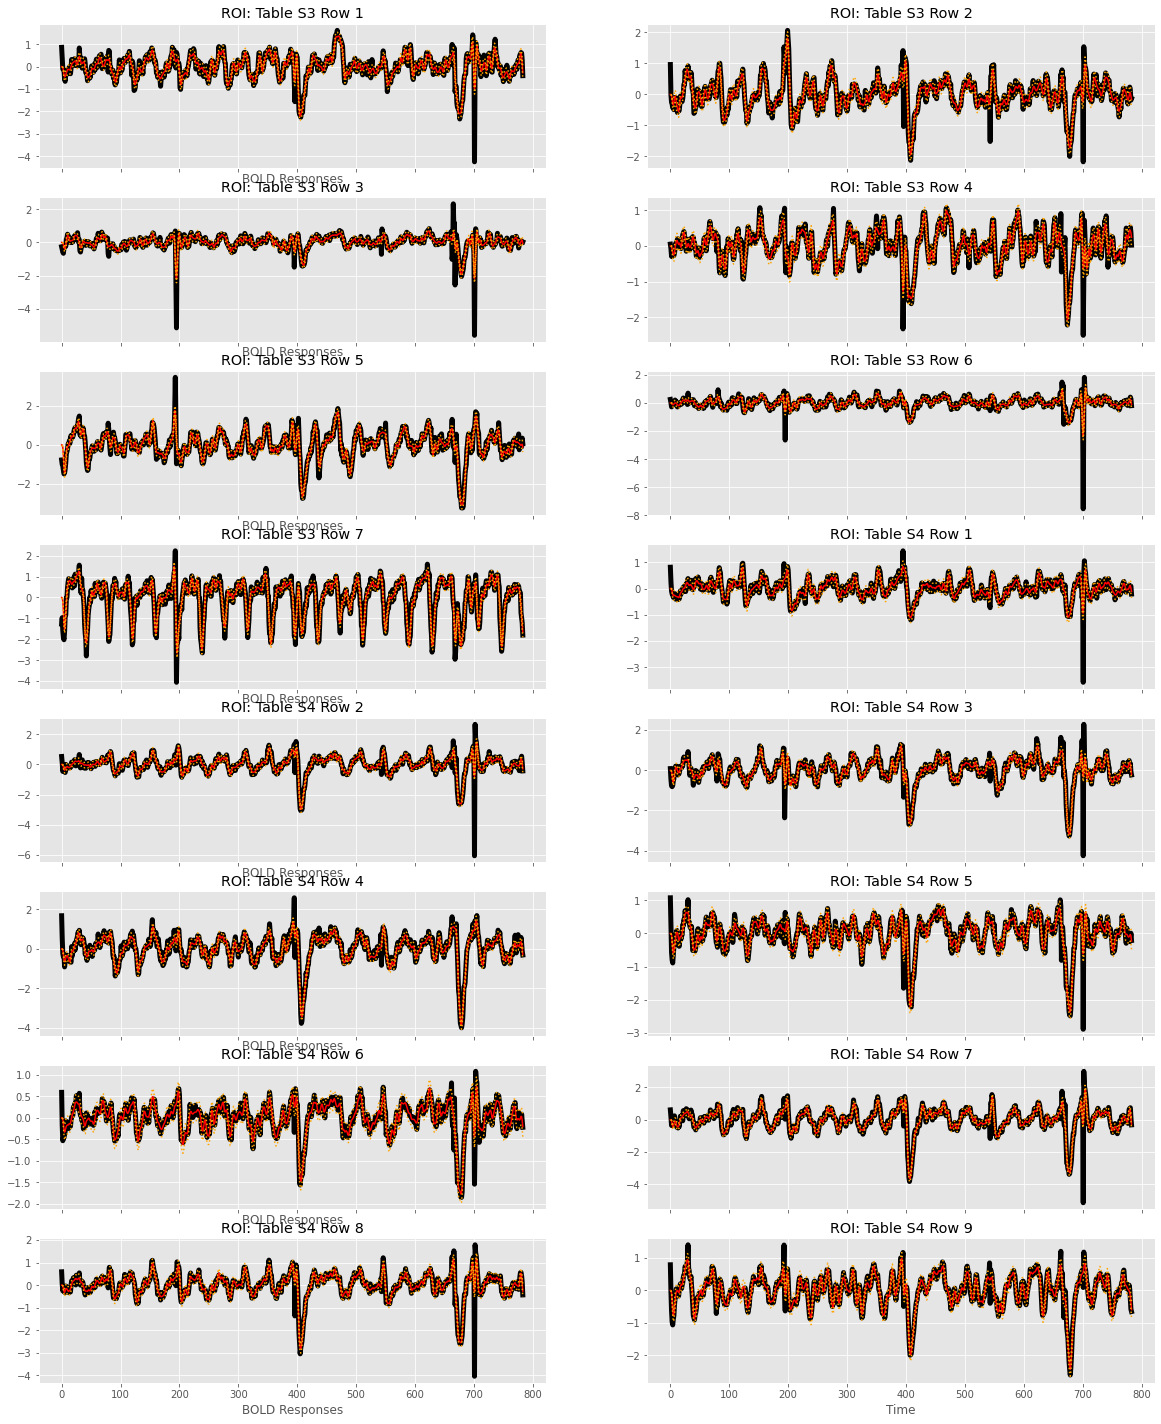

In [ ]:
fig, axs = plt.subplots(8, 2, figsize=(20, 25), sharex=True)
for r in range(8):
    for c in range(2):
        voxel_idx = c+r*2
        if voxel_idx < 16:
            axs[r,c].plot(ts_sparse, Y_N1[:,voxel_idx], c="k", label="Data", linewidth=5)
            axs[r,c].plot(ts_sparse, yhat_arr[:,voxel_idx], c="r", label = "Mean prediction")
            axs[r,c].plot(ts_sparse, yhat_arr[:,voxel_idx] - 1.96 * yhat_sd, c="orange",linestyle=":", label="95% predictive interval")
            axs[r,c].plot(ts_sparse, yhat_arr[:,voxel_idx] + 1.96 * yhat_sd, c="orange",linestyle=":")
            axs[r,c].set_title("ROI: "+label_ROI[voxel_idx])
        if r == 7:
            axs[r,c].set_xlabel("Time")
        if c==0:
            axs[r,c].set_xlabel("BOLD Responses")

## Recovery: Behavioral Data

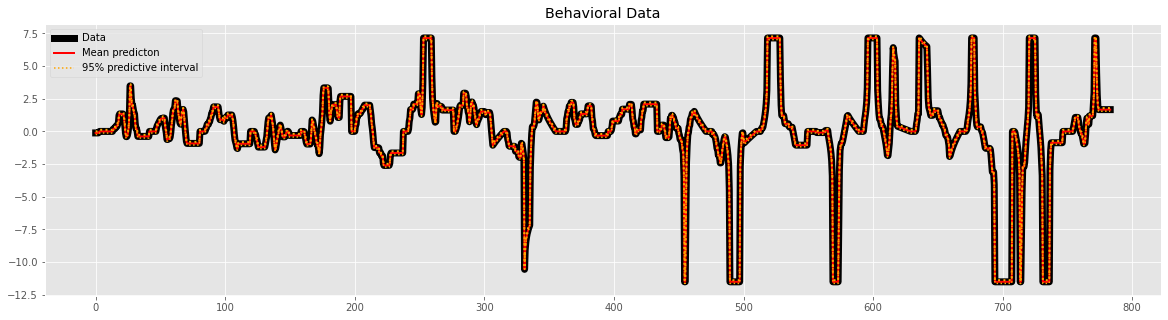

In [ ]:
bmean, bV, bci = recover_behavioral(test, ts_dense)

plt.figure(figsize=(20,5))
plt.plot(ts_dense, Y_B1.ravel(), c="k", linewidth = 7, label="Data")
plt.plot(ts_dense, bmean.ravel(), c="r", label = "Mean predicton", linewidth=2)
plt.plot(ts_dense, bci[:,0], c="orange", linestyle = ":", label="95% predictive interval")
plt.plot(ts_dense, bci[:,1], c="orange", linestyle = ":", linewidth=2)
# plt.plot(bhat3, label = "3-dim")

plt.legend()
plt.title("Behavioral Data")
plt.show()

## Estimated Latent Dynamics

In [ ]:
np.max(test.X[:,0])+6,np.min(test.X[:,0])+6

(8.659739990947141, 2.8072508472707716)

In [ ]:
np.max(test.X[:,1])+1,np.min(test.X[:,1])+1

(4.2283241838649275, -2.7723250161294697)

In [ ]:
np.max(test.X[:,2])-5,np.min(test.X[:,2])-5

(-1.3497623441377042, -9.710939939707423)

Text(0.5, 1.0, 'Latent Dynamics: The three-dimensional space')

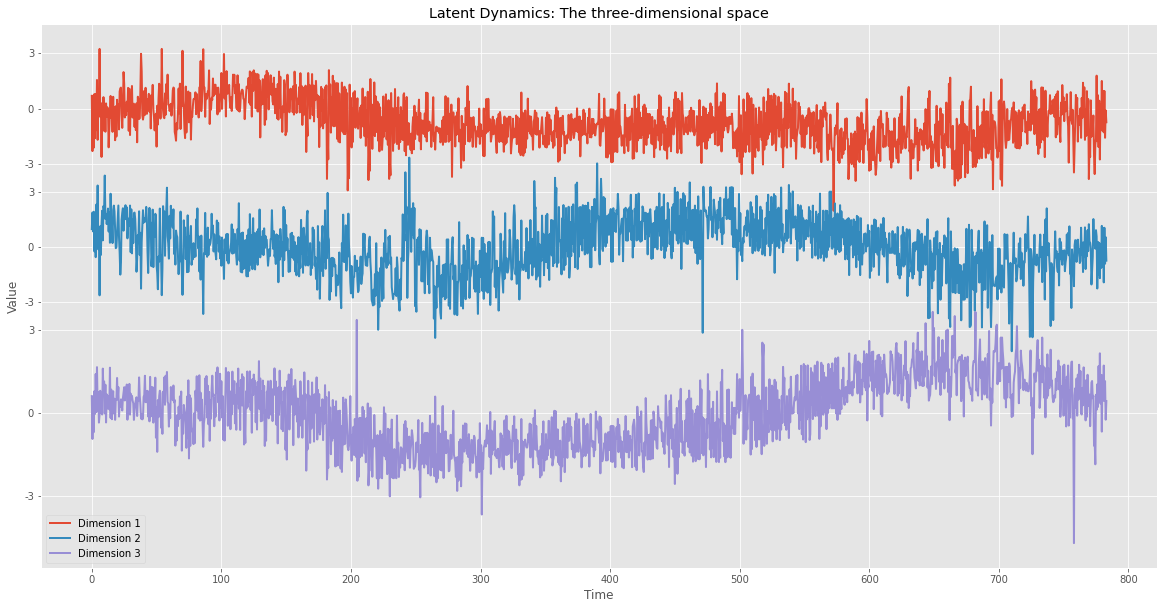

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(ts_dense, test.X[:,0]+5.5, label = "Dimension 1", linewidth=2)
plt.plot(ts_dense, test.X[:,1]+1, label = "Dimension 2", linewidth=2)
plt.plot(ts_dense, test.X[:,2]-5, label = "Dimension 3", linewidth=2)
plt.yticks([-8, -5, -2, -1, 1, 3, 4, 6, 8], [-3, 0, 3, -3, 0, 3, -3, 0, 3])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Latent Dynamics: The three-dimensional space")

Text(0.5, 1.0, 'Latent Dynamics: The three-dimensional space')

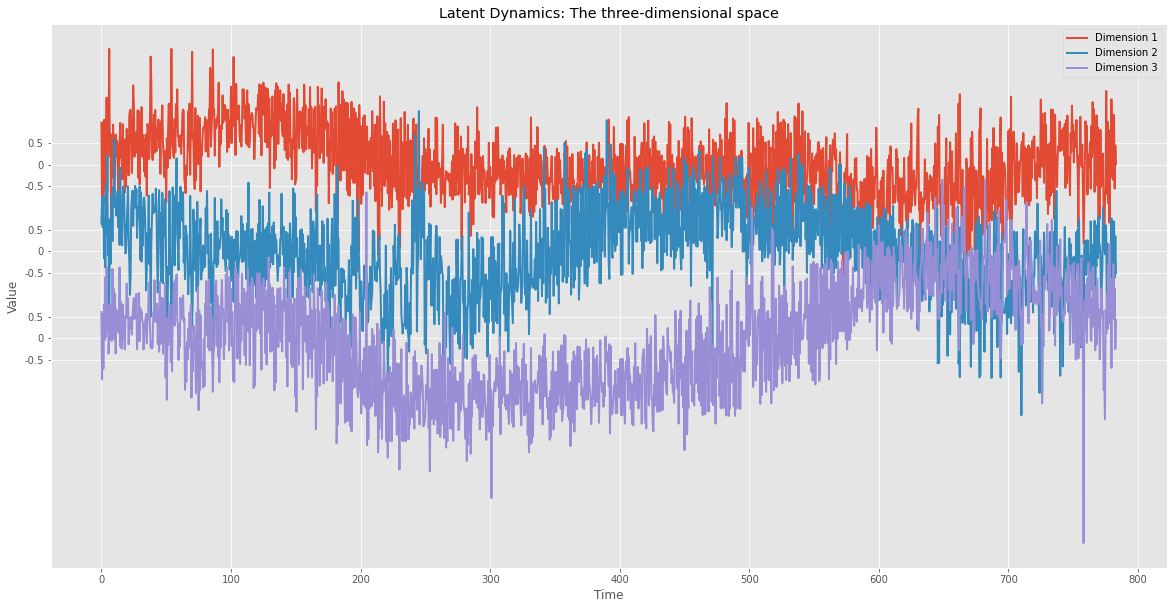

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(ts_dense, test.X[:,0]+3, label = "Dimension 1", linewidth=2)
plt.plot(ts_dense, test.X[:,1]+1, label = "Dimension 2", linewidth=2)
plt.plot(ts_dense, test.X[:,2]-1, label = "Dimension 3", linewidth=2)
plt.yticks([-1.5, -1, -0.5, 0.5, 1, 1.5, 2.5, 3, 3.5], [-.5, 0, .5, -.5, 0, .5, -.5, 0, .5])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Latent Dynamics: The three-dimensional space")